# Build and run pipelines

In Notebook 2 we learn pipelines. Pipeline is a sequence of actions that we want to apply to dataset. Sometimes it is also called a workflow. It helps to organize your work, combining and giving clear names to action sequences that will be reused many times. For example, when you train a model with batches, you repeat the same process for each batch many times: data loading, preprocessing and passing data to the next model training iteration.

![img](http://www.hgpresearch.com/wp-content/uploads/2014/01/workflow3.png)

Instead of maintaining the sequence of actions that can be potentially large enough you simply define a pipeline once and expoit it whenever you need. Moreover, since pipelines only keep a sequence of actions (they itself do not perform any caclulation), it is naturally to expect that we can play with sequences in the same manner as we do it with python lists, for example, contatenate them or repeat several times. Pipelines can do this indeed! It is called pipeline algebra and we consider algebra operations in this tutorial.

## Table of contents
* [Build a simple pipeline](#Build-a-simple-pipeline)
* [Pipeline variables](#Pipeline-variables)
* [Add custom function into pipeline](#Add-custom-function-into-pipeline)
* [Pipeline algebra](#Pipeline-algebra)
* [CardIO pipelines](#CardIO-pipelines)
    * [Train model to detect atrial fibrillation](#Train-model-to-detect-atrial-fibrillation)
    * [Predict atrial fibrillation](#Predict-atrial-fibrillation)
* [Summary](#Summary)

## Build a simple pipeline

Let's start with a very simple pipeline and elaborate it iteratively. In the beginning it will do two actions: load ECG signals and apply filter with 5–40 Hz bandpass. This is typical step in ECG processing. Let's call it ```filter_pipeline```. 

To build a pipeline we initialize it with ```bf.Pipeline()``` statement and append [actions](https://analysiscenter.github.io/cardio/api/cardio.batch.html#methods) from ```EcgBatch```:

In [1]:
import sys
sys.path.append("..")

import cardio.batchflow as bf

filter_pipeline = (bf.Pipeline()
                     .load(fmt="wfdb", components=["signal", "meta"])
                     .band_pass_signals(low=5, high=40))

To run the pipeline we need some dataset to be passed in. Let's create an ECG dataset (see [Notebook 1](https://github.com/analysiscenter/cardio/blob/master/tutorials/I.CardIO.ipynb) for dataset): 

In [2]:
import os
from cardio import EcgDataset

PATH_TO_DATA = "../cardio/tests/data" #set path to data
eds = EcgDataset(path=os.path.join(PATH_TO_DATA, "A*.hea"), no_ext=True, sort=True)

Now we can pass dataset ```eds``` into ```filter_pipeline``` and run the calculation:

In [3]:
(eds >> filter_pipeline).run(batch_size=len(eds), n_epochs=1)

Pipeline is completed. Where are loaded and filtered ECG? Answer: they are destroyed. The point is that when we run pipeline batches are generated and __destroyed__ inside the pipeline. It is reasonable if we train a model and do not need to keep batches. However, at the moment we do not train any model and want to see the effect of ```filter_pipeline```. So we slighlty modify the pipeline and initialize a pipeline variable that will keep batches before and after filtering. 

## Pipeline variables

Sometimes you may need to remember intermediate results within workflows. [Pipeline variable](https://analysiscenter.github.io/dataset/intro/pipeline.html#pipeline-variables) is a flexile tool that solves this issue. Pipeline variable can be list, array, number or any other data structure. 

Recall that we were going to add a variable in ```filter pipeline``` that will keep batches before and after filtering. So we need a list to which we will append batches. Action ```init_variable('saved_batches', init=list)``` in the beginning of pipeline initilaizes a list with name ```'saved_batches'```. Then somewhere within the pipeline we add action ```update_variable``` and specify which variable will be updated, what is a new value and how to update variable (append, extend or rewrite).

Below you can find ```filter_pipeline``` with included ```init_variable``` and ```update_variable``` actions. Note that we apply action ```update_variable``` twice. Each action will append batch in its current state to the list ```saved_batches```. Statement ```B()``` says that we want to keep the whole batch. Alternatively, we could specify particular batch component, e.g. ```B('signal')```. Read [here](https://analysiscenter.github.io/dataset/intro/pipeline.html#updating-a-variable) more about updating of variables.

In [4]:
from cardio.batchflow import B

filter_pipeline = (bf.Pipeline()
                     .init_variable('saved_batches', init_on_each_run=list)
                     .load(fmt="wfdb", components=["signal", "meta"])
                     .update_variable('saved_batches', B(), mode='a')
                     .band_pass_signals(low=5, high=40)
                     .update_variable('saved_batches', B(), mode='a'))

Run the modified pipeline:

In [5]:
filter_pipeline = (eds >> filter_pipeline).run(batch_size=len(eds), n_epochs=1)

Now pipeline variable ```saved_batches``` keeps raw batch (before filtering) and filtered batch. Method ```get_variable``` gets access to the pipeline variable and saved batches:

In [6]:
raw_batch, filtered_batch = filter_pipeline.get_variable('saved_batches')

The figures below shows raw and filtered ECG signal with index 'A00001':

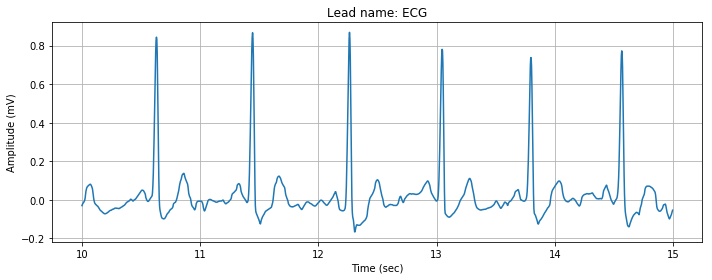

In [7]:
raw_batch.show_ecg('A00001', start=10, end=15)

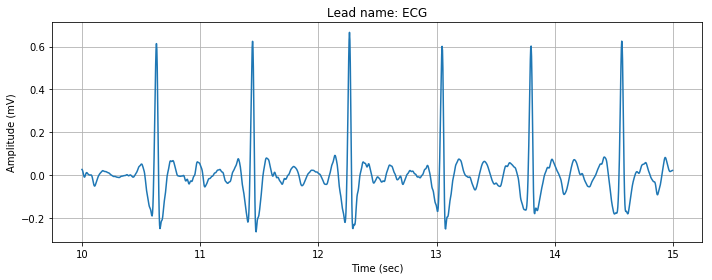

In [8]:
filtered_batch.show_ecg('A00001', start=10, end=15)

## Add custom function into pipeline

Suppose you know some clever method of signal filtering that you want to incorporate into pipeline and that is not in CardIO yet. You can easily include new methods in pipelines using ```apply_transform``` action (see [API](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.apply_transform) for details). As an example consider ```medfilt``` filter from ```scipy.signal``` module and create ```medfilt_pipeline```. We specify which componet will be the input (```signal```), which component will accept the output (```signal``` again), function for transformation (```medfilt```) and all its argumets (```kernel_size```):

In [9]:
from scipy.signal import medfilt

medfilt_pipeline = (bf.Pipeline()
                     .init_variable('saved_batches', init_on_each_run=list)
                     .load(fmt="wfdb", components=["signal", "meta"])
                     .update_variable('saved_batches', B(), mode='a')
                     .apply_transform(func=medfilt, src='signal', dst='signal', kernel_size=(1, 11))
                     .update_variable('saved_batches', B(), mode='a'))

Run pipeline:

In [10]:
medfilt_pipeline = (eds >> medfilt_pipeline).run(batch_size=len(eds), n_epochs=1)

Compare the same segment before and after applying ```medfilt```:

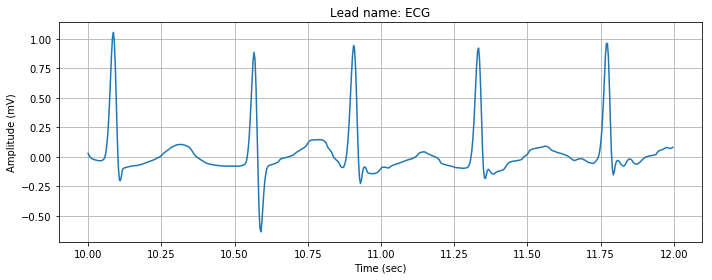

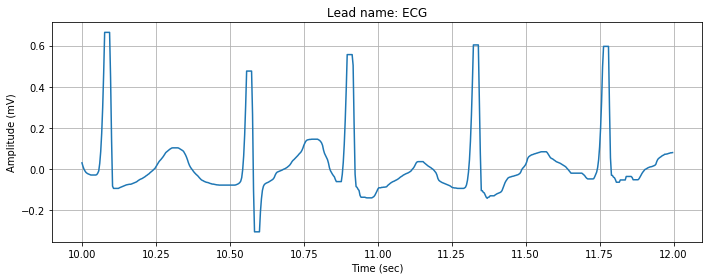

In [11]:
raw_batch, filtered_batch = medfilt_pipeline.get_variable('saved_batches')

raw_batch.show_ecg('A00005', start=10, end=12)
filtered_batch.show_ecg('A00005', start=10, end=12)

In the same manner you can add more custom preprocess methods and build very complex pipelines. Moreover, several pipelines can be combined in a single one using algebra of pipelines. Next section shows how it works.

## Pipeline algebra

Pipeline algebra is a powerful tool to manipulate pipelines. Suppose we have three separate pipelines: one for data loading, one for signal filtering and another one for data augmentation. Although each of them is very simple, let's consider them separately:

In [12]:
load_pipeline = bf.Pipeline().load(fmt="wfdb", components=["signal", "meta"])

filter_pipeline = bf.Pipeline().band_pass_signals(low=5, high=40)

augment_pipeline = (bf.Pipeline()
                      .random_resample_signals("normal", loc=300, scale=10)
                      .random_split_signals(length=3000, n_segments=5)
                      .unstack_signals())

The first two are already known, while ```augment_pipeline``` is a new one. In general it is a good practice to augment data before model training. In ```augment_pipeline``` we resample signal to random frequency and crop 5 random segment of size 3000.

Now we can build a full workflow (load, filter and augmentation) using pipeline algebra. 

In [13]:
full_pipeline = load_pipeline + filter_pipeline + augment_pipeline

The point is that with pipeline aglebra we can easily rearrage workflows, e.g. build a workflow without signal filtering. We will not drop filtering and rather add some actions to save output batch:

In [14]:
with bf.Pipeline() as p:
    full_pipeline = (p.init_variable('saved_batches', init_on_each_run=list) +
                     full_pipeline +
                     p.update_variable('saved_batches', B(), mode='a'))

Run ```full_pipeline``` and consider output batch:

In [15]:
batch = (eds >> full_pipeline).run(batch_size=len(eds), n_epochs=1).get_variable('saved_batches')[0]

Plot several samples that we have obtained after augmentation. Note that original indices 'A00001', 'A00002' and so on don't make sense anymore and we use natural indexing: 0, 1, 2 and so on. 

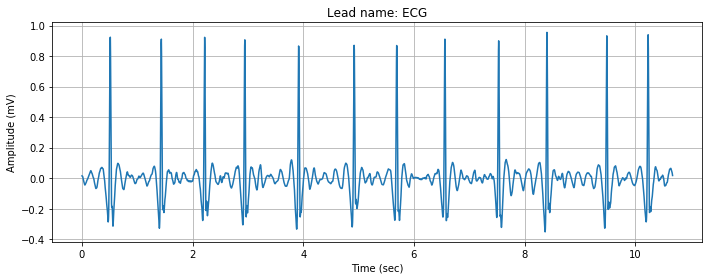

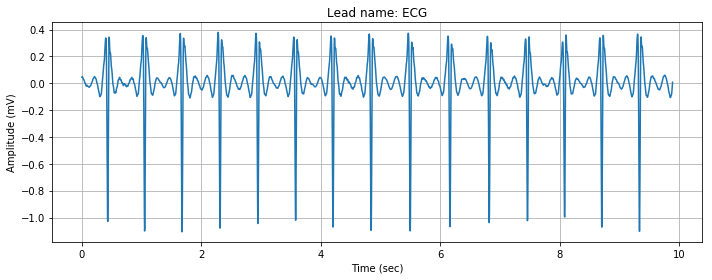

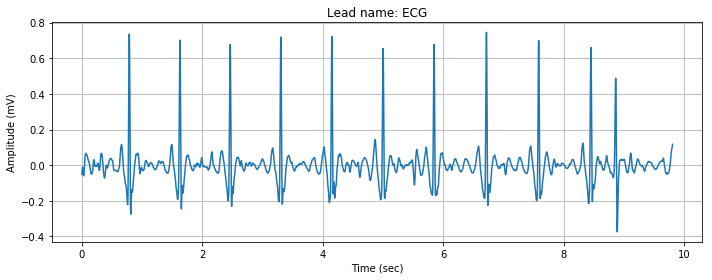

In [16]:
batch.show_ecg(0)
batch.show_ecg(5)
batch.show_ecg(29)

Algebra of pipelines allows to do more complex tricks. We may repeat some pipelines n times (using operation *) and apply pipelines with some probability (using operation @). This is how it may look like:

```python
with Pipeline() as p:
    preprocessing_pipeline = p.first_action() +
                             p.second_action() +
                             p.action_we_want_apply_sometimes @ .8 +
                             p.action_we_want_repeat() * 3 +
                             p.last_action()

```

Read even more about pipelines in [documentation](https://analysiscenter.github.io/dataset/intro/pipeline.html).

## CardIO pipelines

With CardIO you may benefit from using built-in pipelines that allow to reproduce the processes of model training and making predictions. At the moment ```cardio.pipelines``` module contains pipelines for [dirichlet_model](https://analysiscenter.github.io/cardio/api/cardio.models.html#dirichletmodel) that learns to predict atrial fibrillation and [hmm_model](https://analysiscenter.github.io/cardio/api/cardio.models.html#hmmodel) that learns to annotate QRS intervals, T-waves and P-waves in ECG signal. 

Under the hood built-in pipelines contain sequence of actions that load data, process it and transform in order to fit the model input. For example consider the ```dirichlet_train_pipeline```:

```python
(bf.Pipeline()
   .init_model("dynamic", DirichletModel, name="dirichlet", config=model_config)
   .init_variable("loss_history", init_on_each_run=list)
   .load(components=["signal", "meta"], fmt="wfdb")
   .load(components="target", fmt="csv", src=labels_path)
   .drop_labels(["~"])
   .replace_labels({"N": "NO", "O": "NO"})
   .flip_signals()
   .random_resample_signals("normal", loc=300, scale=10)
   .random_split_signals(2048, {"A": 9, "NO": 3})
   .binarize_labels()
   .train_model("dirichlet", make_data=concatenate_ecg_batch,
                fetches="loss", save_to=V("loss_history"), mode="a")
   .run(batch_size=batch_size, shuffle=True, drop_last=True, n_epochs=n_epochs, lazy=True))
```

We are going to demonstrate how to train the dirichlet model with built-in pipeline and make predictions. However, usage of built-in pipelines assumes that we have an appropriate dataset for model training. As such a dataset we suggest to exploit the PhysioNet database of short single lead ECG recording (see [Notebook 1](https://github.com/analysiscenter/cardio/blob/master/tutorials/I.CardIO.ipynb) for more details). From now on we assume that the dataset as well as the reference file with target labels are located in the same directory and PATH_TO_DATA is a path to that directory.

### Train model to detect atrial fibrillation

Let's create a train/test dataset from the PhysioNet database first:

In [17]:
import os
from cardio import EcgDataset

PATH_TO_DATA = "/notebooks/data/ECG/training2017" #set path to data
pds = EcgDataset(path=os.path.join(PATH_TO_DATA, "*.hea"), no_ext=True, sort=True)
pds.split(0.8, shuffle=True)

In the next step we configure the training pipeline. We import function ```dirichlet_train_pipeline``` that creates a pipeline and specify path to the reference file with target labels (see [API](https://analysiscenter.github.io/cardio/api/cardio.pipelines.html#dirichlet-train-pipeline) for more options including GPU configuration):

In [18]:
from cardio.pipelines import dirichlet_train_pipeline
%env CUDA_VISIBLE_DEVICES=0

AF_SIGNALS_REF = os.path.join(PATH_TO_DATA, "REFERENCE.csv")
pipeline = dirichlet_train_pipeline(AF_SIGNALS_REF, batch_size=256, n_epochs=500)

env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


Pass the training part of the dataset and start learning. It may take some time untill we iterate over all epochs:

In [19]:
trained = (pds.train >> pipeline).run()

Save model to use it later for prediction:

In [20]:
model_path = "af_model_dump"
trained.save_model("dirichlet", path=model_path)

### Predict atrial fibrillation

To make predictions with dirichlet model we import ```dirichlet_predict_pipeline``` and specify path to trained model:

In [21]:
from cardio.pipelines import dirichlet_predict_pipeline

pipeline = dirichlet_predict_pipeline(model_path)

INFO:tensorflow:Restoring parameters from af_model_dump/model-13000


Pass the test part of the dataset for prediction. We will find predictions in pipeline variable ```predictions_list```:

In [22]:
res = (pds.test >> pipeline).run()
pred = res.get_variable("predictions_list")

Show some predicted probabilities and corresponding true labels:

In [23]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x["target_pred"]["A"] for x in pred], 
                    index=pds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(20)

,AF prob,True label
A08444,0.06,NO
A07361,0.03,NO
A03626,0.15,NO
A04387,0.54,NO
A02334,0.03,NO
A06449,0.03,NO
A05284,0.07,NO
A04418,0.05,NO
A07200,0.03,NO
A08206,0.03,NO


## Summary

In Notebook 2 we learned about pipelines and algebra of pipelines. Now you can:
* construct and run pipelines
* add custom actions
* concatenate several pipelines using algebra of pipelines
* train neural network to predict atrial fibrillation with built-in pipelines.

In the next [Notebook 3](https://github.com/analysiscenter/cardio/blob/master/tutorials/III.Models.ipynb) we will work with models.